In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
seed = 0
np.random.seed(seed)

## Fetch the jet tagging dataset from Open ML (run this only once, this can take a while)

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

In [3]:
le = LabelEncoder()
yl = le.fit_transform(y)
yc = to_categorical(yl, len(le.classes_))

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
import setGPU

setGPU: Setting GPU to: 0


In [6]:
def History(label, h):
    plt.plot( h.history['loss'], label ='Training Loss: {}'.format(label))
    plt.plot( h.history['val_loss'], label = 'Validation Loss: {}'.format(label))
    plt.plot( h.history['accuracy'], label = 'Training Accuracy: {}'.format(label))
    plt.plot( h.history['val_accuracy'], label = 'Validation Accuracy: {}'.format(label))
    plt.legend()
    plt.show()

In [7]:
def Accuracy(m):
    pred = m.predict( X_test)
    a = accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    print("Accuracy: {}: {}".format(m.name, a))
    return pred, a

## Construct a simple dense model

We'll use variable number of hidden layers with variable numbers of neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Activation, BatchNormalization, Conv1D, Dropout, Reshape, Flatten
from tensorflow.keras.optimizers import Adam

Encapsulate the model creation, training and evaluation in one function

In [9]:
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau

def model_fom(n_layers=3,
              n_neurons=64,
              lr=0.001,
              batch=1024):
    i = Input(shape=(16,))
    d = i
    for il in range(n_layers):
        ls = int(n_neurons/2.) if il==0 else n_neurons
        d = Dense(ls, name='fc{}'.format(il), activation='relu')(d)
    o = Dense(len(le.classes_), activation='softmax', name='output')(d)
    model = Model(inputs=i, outputs=o, name='model_DNN_{}_{}_{:0.6f}_{}'.format(n_layers,n_neurons,lr,batch))
    model.summary()
    model.compile(optimizer=Adam(lr=lr), loss=['categorical_crossentropy'], metrics=['accuracy'])
    stopping = EarlyStopping(monitor='val_loss', 
                         patience=10, 
                         verbose=1, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                              mode='min', verbose=1, min_delta=0.001,
                              cooldown=4, min_lr=1e-5)
    history = model.fit(X_train_val, y_train_val, batch_size=batch,
                        epochs=2, validation_split=0.25, shuffle=True,
                        callbacks = [ stopping,reduce_lr ])
    pred = model.predict( X_test )
    a = accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    print("Accuracy: {}: {}".format(model.name, a))
    return a

Test training

In [10]:
model_fom()

Model: "model_DNN_3_64_0.001000_1024"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
fc0 (Dense)                  (None, 32)                544       
_________________________________________________________________
fc1 (Dense)                  (None, 64)                2112      
_________________________________________________________________
fc2 (Dense)                  (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 5)                 325       
Total params: 7,141
Trainable params: 7,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
487/487 [==============================] - 1s 2ms/step - loss: 1.3014 - accuracy: 0.5380 - v

0.6536807228915663

## Bayesian optimization with GP

Example of parameter minimization using bayesian optimization and a Gaussian process estimation of the landscape

Some material from https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [11]:
def f(args):
    return (args[0]**2 + (args[1]-2)**2)

In [12]:
from skopt import gp_minimize
from skopt.space import Real, Integer

In [13]:
res = gp_minimize(f,
                  [Real(-10.0, 10.0),Real(-10,10)],
                  n_calls=15,
                  acq_func="EI",
                  n_random_starts=5,
                  random_state=1234,
                  verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0007
Function value obtained: 18.9836
Current minimum: 18.9836
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0005
Function value obtained: 16.7733
Current minimum: 16.7733
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0005
Function value obtained: 132.8039
Current minimum: 16.7733
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0005
Function value obtained: 54.8744
Current minimum: 16.7733
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3674
Function value obtained: 140.2118
Current minimum: 16.7733
Iteration No: 6 started

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

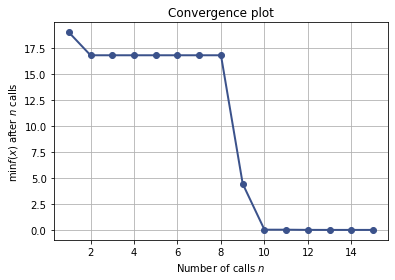

In [14]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [15]:
print(res)
print("Best parameters are:",res.x)

          fun: 0.003234817771962547
    func_vals: array([1.89836180e+01, 1.67733195e+01, 1.32803928e+02, 5.48744107e+01,
       1.40211826e+02, 1.19326029e+02, 1.03250928e+02, 3.12076054e+01,
       4.42845987e+00, 2.40412941e-02, 7.61789256e-01, 6.75682175e-03,
       3.23481777e-03, 8.76634492e-03, 8.84713048e-03])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
            

# Model hyper-parameters optimization

In [16]:
def model_fom_args(args):
    return -1*model_fom(n_layers=args[0],n_neurons=args[1],lr=args[2],batch=args[3])

In [17]:
res = gp_minimize(model_fom_args,
                  [
                      Integer(1, 10),
                      Integer(10,1000),
                      Real(0.000001, 0.1),
                      Integer(10,10000)
                  ],
                  acq_func="EI",
                  n_calls=15,
                  n_random_starts=5,
                  random_state=1234)

Model: "model_DNN_5_820_0.061212_7716"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
fc0 (Dense)                  (None, 410)               6970      
_________________________________________________________________
fc1 (Dense)                  (None, 820)               337020    
_________________________________________________________________
fc2 (Dense)                  (None, 820)               673220    
_________________________________________________________________
fc3 (Dense)                  (None, 820)               673220    
_________________________________________________________________
fc4 (Dense)                  (None, 820)               673220    
_________________________________________________________________
output (Dense)               (None, 5

          fun: -0.7152530120481928
    func_vals: array([-0.20060241, -0.62153012, -0.6038012 , -0.71378916, -0.6905241 ,
       -0.20237952, -0.64609036, -0.20060241, -0.44987952, -0.20165663,
       -0.71525301, -0.69931928, -0.29875301, -0.43268072, -0.70930723])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, rand

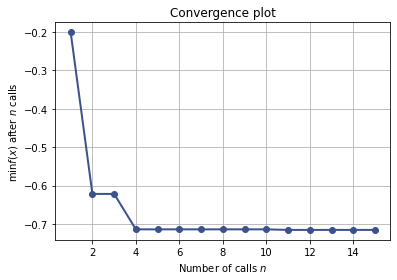

In [18]:
plot_convergence(res)
print(res)
print("Best model parameters are:",res.x)

# Exercises
Add proper convergence with callbacks.

Add the CNN in the same architecture search.

# Challenge
if one adds K-folding to the optimization procedure, how can one use the RMS.